In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

In [3]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_parity(n, d=2, angle_params=None, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-2, 2, size=(10*n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        R = generate_2d_rotation(angle_params)
        X = X @ R
        inds = (abs(X[:, 0]) < 1) + (abs(X[:, 1]) < 1)
        Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
        X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
    return X, Y.astype(int)

def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    

    for i in range(2**k):
        for j in range(2**k):
            if cov_scale == 0:
                temp = np.random.uniform(-1, -1 + 1/2**(k-1), size=(mnt[i*(2**k) + j], d))
            else:
                temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                     size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))

            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
#         Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
#         X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

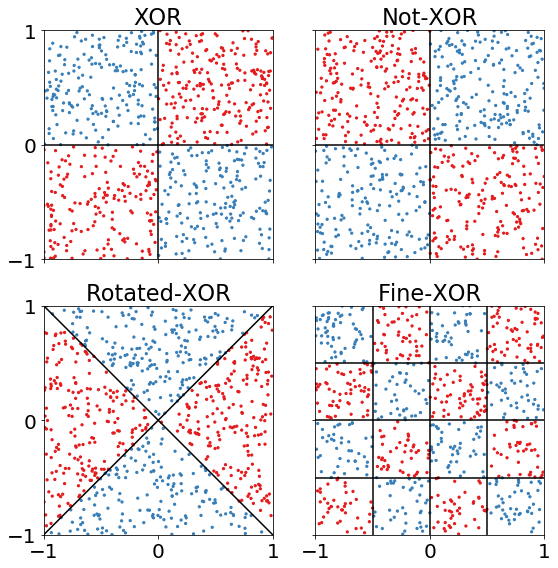

In [4]:
np.random.seed(1)
n=750


colors=sns.color_palette('Set1', n_colors=2)
perm = np.random.choice(n, n, replace=False)

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))
fontsize=22.5
labelsize=20
# shared settings
ax[0, 0].set_ylim(-1, 1)
ax[0, 0].set_xlim(-1, 1)
ax[0,0].set_xticks([-1, 0, 1])
ax[0,0].set_yticks([-1, 0, 1])

cov_scale=0

# XOR
X, Y = generate_gaussian_parity(n, cov_scale=cov_scale, k=1, angle_params=0)

ax[0,0].set_aspect('equal')
ax[0,0].scatter(X[perm,0], X[perm, 1], c=get_colors(colors, Y[perm]), s=5)
ax[0,0].axhline(y=0, c='k')
ax[0,0].axvline(x=0, c='k')
ax[0,0].set_title('XOR', fontsize=fontsize)
ax[0,0].tick_params(labelsize=labelsize)


# N-XOR
X, Y = generate_gaussian_parity(n, cov_scale=cov_scale, k=1, angle_params=np.pi/2)

ax[0,1].set_aspect('equal')
ax[0,1].scatter(X[perm,0], X[perm, 1], c=get_colors(colors, Y[perm]), s=5)
ax[0,1].axhline(y=0, c='k')
ax[0,1].axvline(x=0, c='k')
ax[0,1].set_title('Not-XOR', fontsize=fontsize)
ax[0,1].tick_params(labelsize=labelsize)



# R-XOR
X, Y = generate_parity(n, angle_params=np.pi/4)

ax[1,0].set_aspect('equal')
ax[1,0].scatter(X[perm,0], X[perm, 1], c=get_colors(colors, Y[perm]), s=5)
xr = np.linspace(-1, 1, 2)
ax[1,0].plot(xr, xr, c='k')
ax[1,0].plot(xr, -xr, c='k')
ax[1,0].set_title('Rotated-XOR', fontsize=fontsize)
ax[1,0].tick_params(labelsize=labelsize)


# Chessboard, k = 2 
X, Y = generate_gaussian_parity(n, cov_scale=cov_scale/10, k=2, angle_params=0)

ax[1,1].set_aspect('equal')
ax[1,1].scatter(X[perm,0], X[perm, 1], c=get_colors(colors, Y[perm]), s=5)
ax[1,1].axvline(x=-0.5, c='k')
ax[1,1].axhline(y=-0.5, c='k')
ax[1,1].axvline(x=0, c='k')
ax[1,1].axhline(y=0, c='k')
ax[1,1].axvline(x=0.5, c='k')
ax[1,1].axhline(y=0.5, c='k')
ax[1,1].set_title('Fine-XOR', fontsize=fontsize)
ax[1,1].tick_params(labelsize=labelsize)


# plt.subplots_adjust()
plt.tight_layout()
plt.savefig('figures/task-dissimilarity-1/xor_nxor_rxor_fxor.pdf')
plt.savefig('figures/task-dissimilarity-1/xor_nxor_rxor_fxor.png')